In [5]:
%pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
print(os.path.exists('.env'))  # Should print: True
print(os.getcwd())  # Shows current working directory

True
/Users/roopaldixit/Desktop/100Projects/SentimentAnalysisReddit


In [20]:
import praw
import os

from dotenv import load_dotenv

client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_CLIENT_SECRET')
user_agent = os.getenv('REDDIT_USER_AGENT')

# Fill in your credentials from Reddit
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent

)

subreddit = reddit.subreddit('stocks')
posts = []
for stock in ['AAPL', 'GOOGL', 'AMZN', 'META', 'NFLX']:
    for post in subreddit.search(stock, sort='new', limit=50):
        posts.append({
            'symbol': stock,
            'title': post.title,
            'selftext': post.selftext,
            'created_utc': post.created_utc
        })

print(f"Collected {len(posts)} posts.")


Collected 250 posts.


In [18]:
import pandas as pd
import re

# If you already have your posts list from scraping:
# posts = [{'symbol': ..., 'title': ..., 'selftext': ..., 'created_utc': ...}, ...]

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(posts)

# Combine the title and selftext
df['full_text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

# Remove URLs and special characters, keep only text and numbers
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove special chars
    return text.lower().strip()

df['clean_text'] = df['full_text'].apply(clean_text)

print(df[['symbol', 'clean_text']].head())


  symbol                                         clean_text
0   AAPL  rstocks daily discussion  fundamentals friday ...
1   AAPL  excel sheet to mock portfolio i have a googlee...
2   AAPL  aapl strong iphone 17 demand apple has asked s...
3   AAPL  rstocks daily discussion  fundamentals friday ...
4   AAPL  goog and meta bull goog and meta is the future...


In [19]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each cleaned post
df['sentiment_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

print(df[['symbol', 'sentiment_score']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/roopaldixit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  symbol  sentiment_score
0   AAPL           0.9730
1   AAPL           0.2960
2   AAPL           0.9652
3   AAPL           0.9730
4   AAPL           0.3612


In [22]:
avg_sentiment = df.groupby('symbol')['sentiment_score'].mean().reset_index()
print(avg_sentiment)


  symbol  sentiment_score
0   AAPL         0.703498
1   AMZN         0.546676
2  GOOGL         0.717678
3   META         0.667672
4   NFLX         0.524560


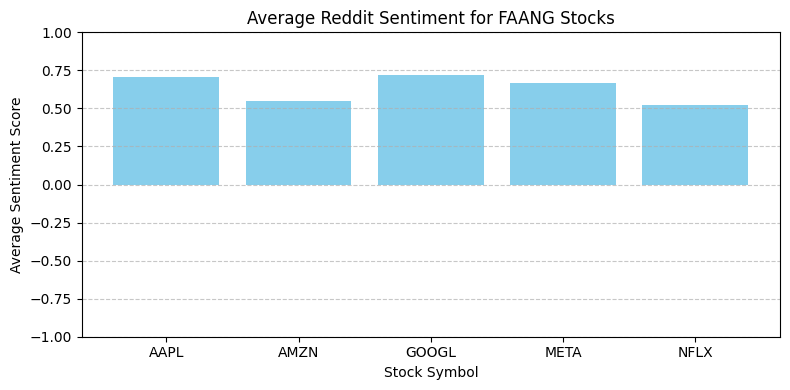

In [23]:
import matplotlib.pyplot as plt

# Assuming avg_sentiment DataFrame from previous step
# If not, run this:
avg_sentiment = df.groupby('symbol')['sentiment_score'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(avg_sentiment['symbol'], avg_sentiment['sentiment_score'], color='skyblue')
plt.title('Average Reddit Sentiment for FAANG Stocks')
plt.xlabel('Stock Symbol')
plt.ylabel('Average Sentiment Score')
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


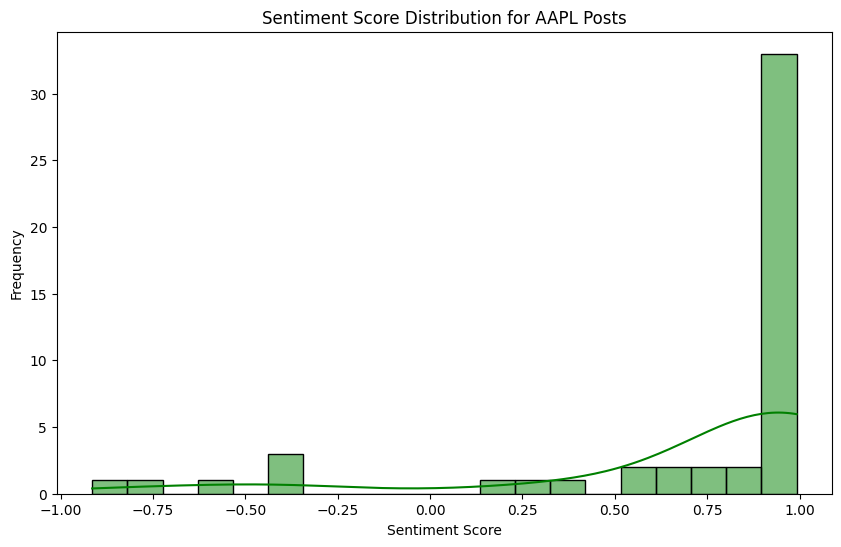

In [24]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df[df['symbol'] == 'AAPL']['sentiment_score'], bins=20, kde=True, color='green')
plt.title('Sentiment Score Distribution for AAPL Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


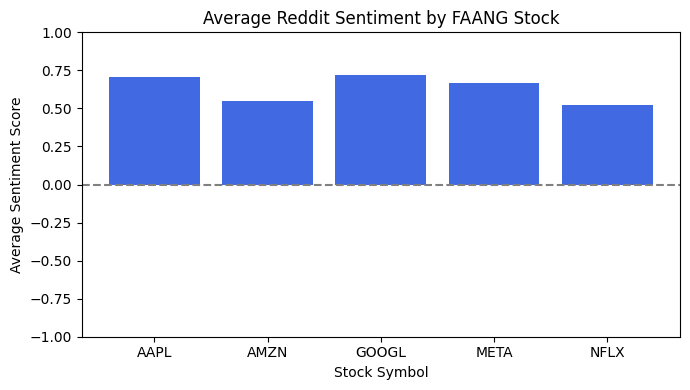

In [25]:
import matplotlib.pyplot as plt

# If you followed the last step, you have avg_sentiment:
# avg_sentiment = df.groupby('symbol')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(7,4))
plt.bar(avg_sentiment['symbol'], avg_sentiment['sentiment_score'], color='royalblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Reddit Sentiment by FAANG Stock')
plt.xlabel('Stock Symbol')
plt.ylabel('Average Sentiment Score')
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()


In [26]:
import yfinance as yf

# Dates for your posts (convert timestamps to date)
df['date'] = pd.to_datetime(df['created_utc'], unit='s').dt.date

# Get daily sentiment per stock
daily_sentiment = df.groupby(['symbol', 'date'])['sentiment_score'].mean().reset_index()

# Download prices for each stock
all_prices = []
for stock in ['AAPL', 'GOOGL', 'AMZN', 'META', 'NFLX']:
    ticker = yf.Ticker(stock)
    prices = ticker.history(period='14d')[['Close']]
    prices = prices.reset_index()
    prices['symbol'] = stock
    prices['date'] = prices['Date'].dt.date
    all_prices.append(prices[['symbol', 'date', 'Close']])

price_df = pd.concat(all_prices, ignore_index=True)

# Merge sentiment with price on symbol and date
merged = pd.merge(daily_sentiment, price_df, on=['symbol', 'date'])
print(merged.head())


  symbol        date  sentiment_score       Close
0   AAPL  2025-09-12           0.9730  234.070007
1   AAPL  2025-09-17          -0.3818  238.990005
2   AAPL  2025-09-19           0.6671  245.500000
3   AAPL  2025-09-25           0.2960  256.869995
4   AAPL  2025-09-26           0.9730  255.460007


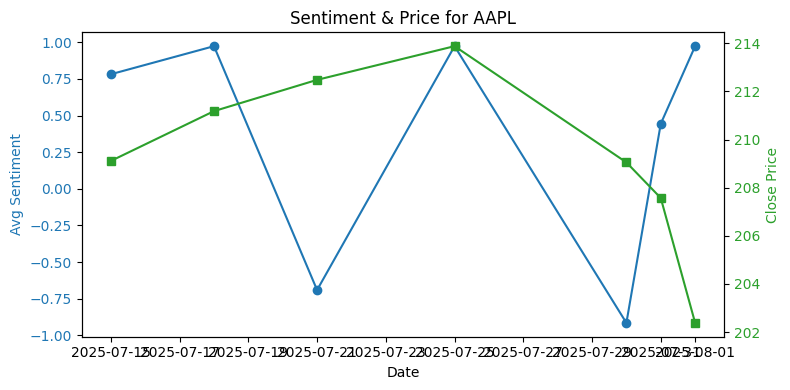

In [9]:
import matplotlib.pyplot as plt

stock = 'AAPL'
df_stock = merged[merged['symbol'] == stock]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Sentiment', color='tab:blue')
ax1.plot(df_stock['date'], df_stock['sentiment_score'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Close Price', color='tab:green')
ax2.plot(df_stock['date'], df_stock['Close'], color='tab:green', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title(f'Sentiment & Price for {stock}')
fig.tight_layout()
plt.show()


In [27]:
# Sort by stock and date
merged = merged.sort_values(['symbol', 'date'])

# Add movement label
merged['price_next'] = merged.groupby('symbol')['Close'].shift(-1)
merged['goes_up'] = (merged['price_next'] > merged['Close']).astype(int)

# Drop last day (no future price)
ml_data = merged.dropna(subset=['price_next'])

# Features: sentiment_score; Target: goes_up
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = ml_data[['sentiment_score']]
y = ml_data['goes_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.375
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.00      0.00      0.00         5

    accuracy                           0.38         8
   macro avg       0.19      0.50      0.27         8
weighted avg       0.14      0.38      0.20         8



/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()